### 목차

#### Articls & User
- 모델 관계 설정
- CREATE / READ / UPDATE / DELETE

#### Comment & User
- 모델 관계 설정
- CREATE / READ / UPDATE / DELETE

#### View decorators
- Allowed HTTP methods

#### ERD
- ERD 구성 요소
- ERD 제작 사이트

#### 참고
- 추가 기능 구현

# 개요
- Article(N) - User(1)
- Comment(N) - User(1)

# Article(N) & User(1)
## 1. Article & User 모델 관계 설정
```python
# articles/models.py

from django.conf import settings

class Article(models.Model):
    user = models.ForeignKey(settings.AUTH_USER_MODEL, on_delete=models.CASCADE)
```

### User 모델을 참조하는 2가지 방법
- get_user_model()
    - 반환값 : User Object(객체)
    - 사용 위치 : modles.py가 아닌 모든 위치
- settings.AUTH_USER_MODEL
    - 반환값 :accounts.User(문자열)
    - 사용 위치 : models.py

## 2. Migration
- 기존에 테이블이 있는 상황에서 필드를 추가하는 것이기 때문에 안내 메시지가 뜸 -> 1 입력
- 추가하는 외래 키 필드에도 어떤 데이터를 넣을 것인지 입력해야함 -> 1 입력
    - 기존에 작성된 게시글이 있다면 모두 1번 회원이 작성한 것으로 처리됨
- migrations 파일 생성 후 migrate 진행



## 3. 게시글 CREATE

### 1) articles/forms.py
```python 

class ArticleForm(forms.ModelForm):
    class Meta:
        model = Article
        fields = ('totle', 'content',)
```
- 불필요하게 외래 키 데이터 입력하는 것을 방지하기 위해 필드를 수정함
-
### 2) articles/views.py
```python
@login_required
def create(request):
    if request.method == 'POST':
        form = ArticleForm(request.POST)
        if form.is_valid():
            article = form.save(commit = False)
            article.user = request.user
            article.save()
            return redirect('articles:detail', article.pk)
    else:
        form = ArticleForm()
    context = {
        'form': form,
    }
    return render(request, 'articles/create.html', context)
```
- 게시글 작성 시 작성자 정보가 함께 저장될 수 있도록 save의 commit 옵션 활용

## 4. 게시글 READ
### 1) articles/index.html
```html
  {% for article in articles %}
    <p>작성자 : {{article.user}}</p>
    <p>글 번호: {{ article.pk }}</p>
    <a href="{% url "articles:detail" article.pk %}">
      <p>글 제목: {{ article.title }}</p>
    </a>
    <p>글 내용: {{ article.content }}</p>
    <hr>
  {% endfor %}
```
### 2) articles/detail.html
```html
  <h1>Detail</h1>
  <h3>{{ article.pk }}번째 글</h3>
  <hr>
  <p>작성자 : {{article.user}}</p>
```


## 5. 게시글 UPDATE
- 게시글 수정 요청 사용자와 게시글 작성 사용자를 비교하여 본인의 게시글만 수정할 수 있도록 하기
### 1) articles/views.py
```python
@login_required
def update(request, pk):
    article = Article.objects.get(pk=pk)
    if request.user == article.user :
        if request.method == 'POST':
            form = ArticleForm(request.POST, instance=article)
            if form.is_valid():
                form.save()
                return redirect('articles:detail', article.pk)
        else:
            form = ArticleForm(instance=article)
    else :
        return redirect('articles:index')
    context = {
        'article': article,
        'form': form,
    }
    return render(request, 'articles/update.html', context)
```

### 2) articles/detail.html
```html
  {% if request.user == article.user %}
    <a href="{% url "articles:update" article.pk %}">수정</a><br>
    <form action="{% url "articles:delete" article.pk %}" method="POST">
      {% csrf_token %}
      <input type="submit" value="삭제">
    </form>
  {% endif %}
```
- 해당 게시글의 작성자가 아니라면 수정/삭제 버튼을 출력하지 않도록 하기


## 6. 게시글 DELETE
- 게시글 수정 요청 사용자와 게시글 작성 사용자를 비교하여 본인의 게시글만 삭제할 수 있도록 하기
### 1) articles/views.py
```python
@login_required
def delete(request, pk):
    article = Article.objects.get(pk=pk)
    if request.user == article.user :
        article.delete()
    return redirect('articles:index')
```


# Comment & User
## Comment & User 모델 관계 설정
### 1) articles/models.py
```python
class Comment(models.Model):
    # article = models.ForeignKey(상대 모델 클래스, 상대 모델 클래스가 삭제되었을 때 댓글을 어떻게 처리할지)
    article = models.ForeignKey(Article, on_delete=models.CASCADE)
    user = models.ForeignKey(settings.AUTH_USER_MODEL, on_delete=models.CASCADE)
```

### 2) Migrate

### 3) articles/views.py
``` python
def comments_create(request, pk):
    # 어떤 게시글에 작성되는지 게시글을 조회
    article = Article.objects.get(pk=pk)
    comment_form = CommentForm(request.POST)

    if comment_form.is_valid():
        comment = comment_form.save(commit=False)
        comment.article = article
        comment.user = request.user
        comment.save()
        return redirect('articles:detail', article.pk)
        
    context = {
        'article': article,
        'comment_form': comment_form,
    }
    return render(request, 'articles/detail.html', context)
```
- 댓글 작성 시 작성자 정보가 함께 저장될 수 있도록 작성

## 댓글 READ
### articles/detail.html
```html
  <h4>댓글 목록</h4>
  <p>{{ comments|length }}개의 댓글이 있습니다.</p>
  <ul>
    {% for comment in comments %}
      <li>
        {{ comment.user }} - {{ comment.content }}
        <form action="{% url "articles:comments_delete" article.pk comment.pk %}" method="POST">
          {% csrf_token %}
          <input type="submit" value="삭제">
        </form>
      </li>
    {% endfor %}
  </ul>
```
- 댓글 출력 시 댓글 작성자와 함께 출력

## 댓글 DELETE
### articles/views.py
```python
def comments_delete(request, article_pk, comment_pk):
    comment = Comment.objects.get(pk=comment_pk)
    article = Article.objects.get(pk=article_pk)
    if request.user == comment.user :
        comment.delete()
    return redirect('articles:detail', article.pk)
```
### articles/detail.html
```html
  <ul>
    {% for comment in comments %}
      <li>
        {{ comment.user }} - {{ comment.content }}
        {% if request.user == comment.user %}
          <form action="{% url "articles:comments_delete" article.pk comment.pk %}" method="POST">
            {% csrf_token %}
            <input type="submit" value="삭제">
          </form>
        {% endif %}
      </li>
    {% endfor %}
  </ul>
```

# View decorators
- Allowed HTTP methods : 특정 HTTP method로만 view 함수에 접근할 수 있도록 제한하는 데코레이터
- 주요 Allowed HTTP methods
  - 1. require_http_methods(["METHOD01","METHOD02",...])
    - 지정된 HTTP method만 허용
    -  ```python
          from django.views.decorators.http import require_http_methods

          @require_http_methods(['GET','POST'])
          def func(request):
            pass
        ```

  - 2. require_safe()
    - GET과 HEAD method만 허용
    -  ```python
      from django.views.decorators.http import require_safe

      @require_safe
      def func(request):
        pass
    ```

  - 3. require_POST()
    - POST method만 허용
    - ```python
      from django.views.decorators.http import require_POST

      @require_POST
      def func(request):
        pass
      ```
- 특징
  - 지정되지 않은 HTTP method로 요청이 들어오면 HttpResponseNotAllowed(405)를 반환
  - 대문자로 HTTP method를 지정
- require_GET 대신 require_safe를 권장하는 주요 이유
  - 웹 표준 준수 : GET과 HEAD는 안전한 메소드로 간주됨
  - 호환성 : 일부 소프트웨어는 HEAD 요청에 의존
  - 웹 표준을 준수하고 더 넓은 범위의 클라이언트와 호환되며, 안전한 HTTP 메소드만을 허용하는 view 함수를 구현할 수 있음

# ERD
- 데이터베이스의 구조를 시각적으로 표현하는 도구
- Entity(개체), 속성 그리고 엔티티간의 관계를 그래픽 형태로 나타내어 시스템의 논리적 구조를 모델링하는 다이어그램

## ERD의 구성 요소
1. 엔티티(Entity)
- 데이터베이스에 저장되는 객체나 개념 ex) 고객, 주문, 제품
2. 속성(Attribute)
- 엔티티의 특성이나 성질 ex) 고객(이름, 주소, 전화번호)
3. 관계(Relationship)
- 엔티티 간의 연관성  ex) 고객이 '주문'한 제품

### 개체와 속성
- 개체 : 회원(User)
- 속성 : 회원번호(id), 이름(name), 주소(adress) 등 개체가 지닌 속성 및 속성의 데이터 타입
- 관계 : 회원과 댓글 간의 관계 

### Cardinality
- 한 엔티티와 다른 엔티티 간의 수적 관계를 나타내는 표현
- 주요 유형
1. 일대일
2. 다대일
3. 다대다

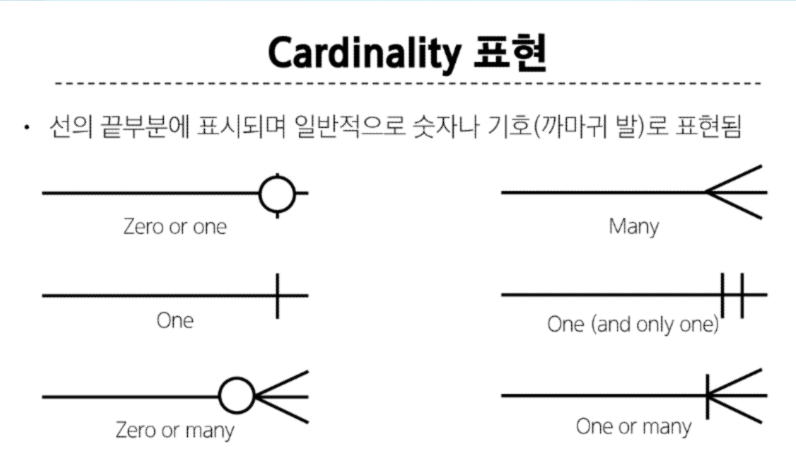
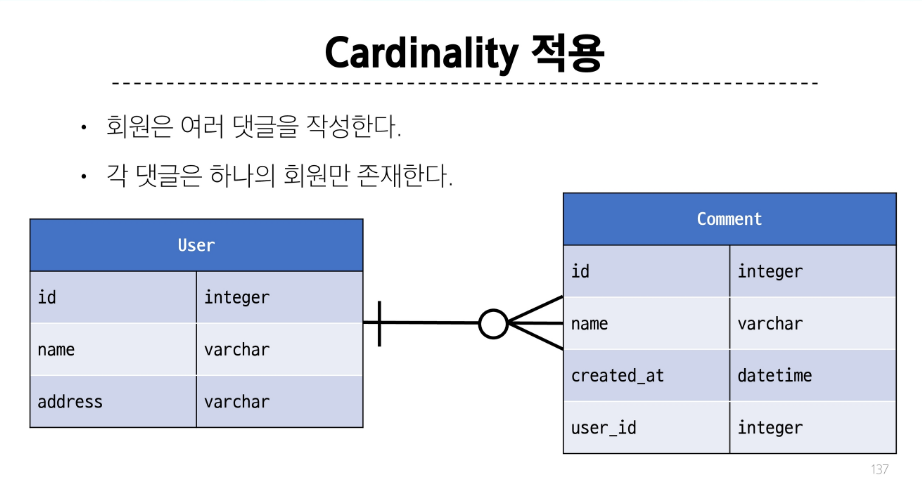

### ERD의 중요성
- 데이터베이스 설계의 핵심 도구
- 시각적 모델링으로 효과적인 의사소통 지원
- 실제 시스템 개발 전 데이터 구조 최적화에 중요
### ERD 제작 사이트
- Draw.io, ERD Cloud